# Описание проекта

**Контекст** - сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основ«Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей.

**Цель** - провести анализ и подготовить план действий по удержанию клиентов. А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

### План
1. [Загрузить и подготовить данные к анализу](#step1)

2. [Провести исследовательский анализ данных (EDA)](#step2)
    - [Выводы](#step2.1)
    
    
3. [Построить модель прогнозирования оттока пользователей](#step3)
    - [Логистическая регрессия](#step3.1)
    - [Случайный лес](#step3.2)
    - [Выводы](#step3.3)
    
 

4. [Сделать кластеризацию пользователей](#step4)
    - [Выводы](#step4.1)


5. [Сформулировать выводы и сделать базовые рекомендации по работе с клиентами](#step5)

# Шаг 1. Загрузка и подготовка данных <a id="step1"></a> 

## Загрузка и предварительный взгляд <a id="step1.1"></a> 

Загрузим библиотеки и датасет. Выведем информацию о нем, первые 10 строк и посмотрим наличие дубликатов. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_palette('Set2')
plt.style.use('seaborn-white')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head(10)
gym_churn.info()
gym_churn.duplicated().sum()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.2275,5.0000,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12.0000,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1.0000,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12.0000,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1.0000,3,1.1139,1.1201,0
5,1,1,0,0,1,1,1,34,450.7440,1.0000,3,2.6235,2.6370,0
6,1,1,1,1,0,6,1,32,94.2664,6.0000,2,1.1389,1.2772,0
7,0,1,0,0,1,1,0,30,217.7866,1.0000,0,1.2135,1.0494,1
8,1,1,1,1,1,1,1,23,45.4099,1.0000,1,1.1062,1.0593,0
9,0,1,0,0,1,1,0,31,65.3108,1.0000,11,1.8109,1.9514,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


0

Итак, в таблице 4000 строк, датасет выглядит чистым, пропущенных значений и дубликатов нет. Надо перевести названия столбцов в нижний регистр для удобства работы с ними. Переменная `Month_to_end_contract` записана как `float`, но значения по сути являются `interger`, тип лучше будет поменять.

Целевая переменная - `Churn`. Имеется 13 признаков, из них 6 (`gender`, `Near_Location`, `Partner`, `Promo_friends`, `Phone`, `Group_visits`) - бинарные признаки со значениями 0 и 1, остальные - количественные, кроме переменной `Contract_period`, которая имеет тип `interger`, хотя по сути является категориальной (видно как минимум три категории - 1, 6, 12 месяцев на абонемент). Ее надо будет преобразовать для применения моделей логистической регрессии и случайного леса.  

## Подготовка данных <a id="step1.2"></a> 

Переведем названия столбцов в нижний регистр.

In [4]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Переведем `month_to_end_contract` в `interger`.

In [5]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

Посмотрим значения переменных `contract_period`, `month_to_end_contract`, `lifetime`.

In [6]:
for col in ['contract_period', 'month_to_end_contract', 'lifetime']:
    col
    gym_churn[col].sort_values().unique()

'contract_period'

array([ 1,  6, 12])

'month_to_end_contract'

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

'lifetime'

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 31])

Действительно, в датасете только три типа абонементов - на 1, 6 и на 12 месяцев. Преобразовывать этот столбец будем после исследовательского анализа данных. В `month_to_end_contract` и `lifetime` ошибок не видно. 

Убедимся, что переменные `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn` - принимают только два значения, 0 или 1.

In [7]:
binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

for col in binary_features:
    col
    gym_churn[col].unique()

'gender'

array([1, 0])

'near_location'

array([1, 0])

'partner'

array([1, 0])

'promo_friends'

array([1, 0])

'phone'

array([0, 1])

'group_visits'

array([1, 0])

'churn'

array([0, 1])

Да, ошибок нет.

Данные готовы к исследовательскому анализу. 

# Шаг 2. Исследовательский анализ данных (EDA) <a id="step2"></a> 

Сначала посмотрим средние значения бинарных признаков.

In [8]:
gym_churn[binary_features].mean()

gender          0.5102
near_location   0.8452
partner         0.4868
promo_friends   0.3085
phone           0.9035
group_visits    0.4123
churn           0.2652
dtype: float64

Итак, можно предпоположить следующее:
- отток клиентов составляет 26.5%,
- процентное соотношение мужчин и женщин примерно одинаковое,
- большинство клиентов живут или работают неподалеку от фитнес-центра,
- примерно половина пользуется партнерской программой,
- с 90% клиентов можно связаться по телефону,
- около 40% посещают групповые программы.

Посмотрим на процентное соотношение видов абонементов.

In [9]:
gym_churn.contract_period.value_counts(normalize=True)

1    0.5517
12   0.2400
6    0.2082
Name: contract_period, dtype: float64

55% клиентов покупают абонементы на один месяц, 24% - на 12 и около 20% - на полгода.

Теперь посмотрим на базовую статистику по количественным признакам.

In [10]:
num_features = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

In [11]:
gym_churn[num_features].describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,"4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000","4,000.0000"
mean,29.1842,146.9437,4.3228,3.7247,1.8790,1.7671
std,3.2584,96.3556,4.1913,3.7493,0.9722,1.0529
min,18.0000,0.1482,1.0000,0.0000,0.0000,0.0000
25%,27.0000,68.8688,1.0000,1.0000,1.1809,0.9630
50%,29.0000,136.2202,1.0000,3.0000,1.8328,1.7196
75%,31.0000,210.9496,6.0000,5.0000,2.5361,2.5103
max,41.0000,552.5907,12.0000,31.0000,6.0237,6.1468


Можно сказать, что:
- средний возраст клиентов - 30 лет, при этом максимальный - всего 41,
- суммарная выручка от других услуг фитнес-центра составляет 147 у.е. на клиента,
- среднее время посещений - 3 месяца,
- клиенты ходят в фитнес-центр примерно два раза в неделю.

Поскольку есть переменная с большим стандартным отклонением (`avg_additional_charges_total`), данные надо будет стандартизировать для обучения моделей, чтобы она не доминировала над остальными переменными. 

Теперь посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался, и построим графики распределения признаков. 

In [12]:
binary_features.remove('churn')
gym_churn.groupby('churn')[binary_features].mean().T

churn,0,1
gender,0.5100,0.5108
near_location,0.8731,0.7681
partner,0.5342,0.3553
promo_friends,0.3535,0.1838
phone,0.9037,0.9029
group_visits,0.4641,0.2686


Посмотрим графики.

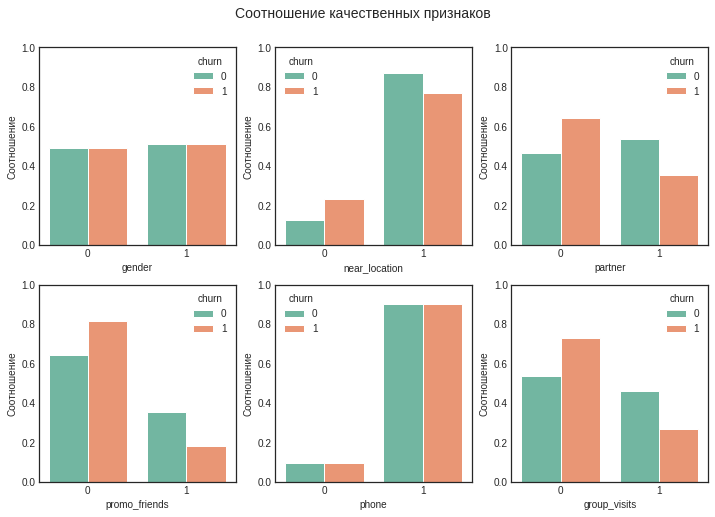

In [13]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
_ = fig.suptitle('Соотношение качественных признаков', fontsize=14, y = .95)
for ax, col in zip(axes.flat, binary_features):
    ratio = gym_churn.groupby('churn')[col].value_counts(normalize=True).rename('Соотношение').reset_index()
    _ = sns.barplot(x=col, y='Соотношение', hue='churn', data=ratio,  ax=ax)
    _ = ax.set(ylim = (0,1))

plt.show()

Средние значения и графики показывают, что на отток может влиять:
- местоположение клиента (дальше от фитнес-центра),
- партнерская программа (уходящие клиенты в ней не участвуют),
- акция "приведи друга" (также не участвуют),
- посещение групповых программ (меньше их посещают).

Пол и наличие номера телефона не влияют.

Посмотрим на количественные признаки по среднему и построим гистограммы и графики распределения.

In [14]:
gym_churn.groupby('churn')[num_features].agg(['std', 'mean', 'median']).T

churn                                           0        1
age                               std      3.0099   2.8952
                                  mean    29.9765  26.9896
                                  median  30.0000  27.0000
avg_additional_charges_total      std     99.8016  77.6964
                                  mean   158.4457 115.0829
                                  median 149.8812 103.8147
month_to_end_contract             std      4.3635   1.9646
                                  mean     5.2831   1.6626
                                  median   6.0000   1.0000
lifetime                          std      3.8748   1.1108
                                  mean     4.7118   0.9906
                                  median   4.0000   1.0000
avg_class_frequency_total         std      1.0160   0.6947
                                  mean     2.0249   1.4750
                                  median   2.0433   1.4912
avg_class_frequency_current_month std      1.0190   0.7702
                                  mean     2.0279   1.0445
                                  median   2.0467   0.9794

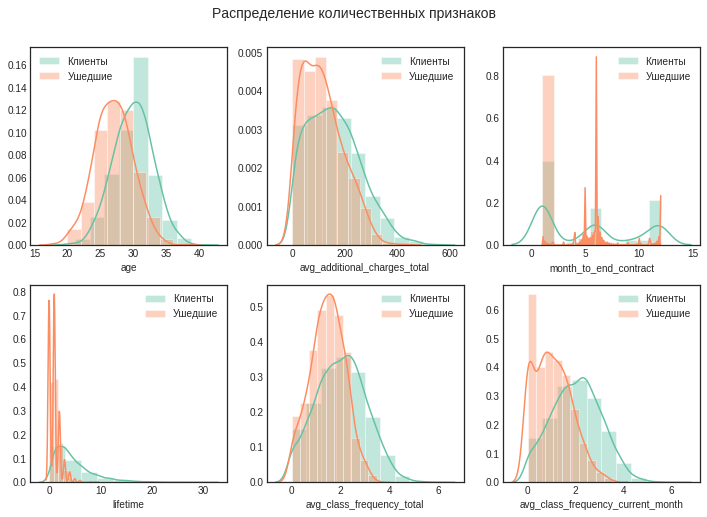

In [15]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
_ = fig.suptitle('Распределение количественных признаков', fontsize=14, y = .95)
for ax, col in zip(axes.flat, num_features):
    _ = sns.distplot(gym_churn.query('churn==0')[col], bins=10, ax=ax, label ='Клиенты')
    _ = sns.distplot(gym_churn.query('churn==1')[col], bins=10, ax=ax, label ='Ушедшие')
    _ = ax.legend()
    
plt.show()

Отдельно построим barplot для сравнения длительности абонементов.

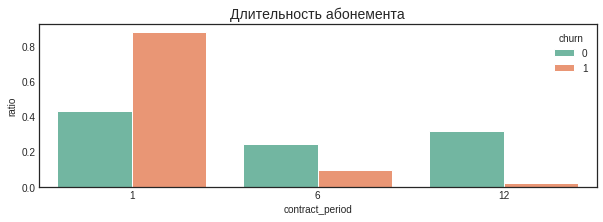

In [16]:
contract_period = gym_churn.groupby('churn')['contract_period'].value_counts(normalize=True).rename('ratio')\
                           .reset_index()
_ = plt.figure(figsize=(10, 3))
_ = sns.barplot(data=contract_period, x='contract_period', y='ratio', hue='churn')
_ = plt.title('Длительность абонемента', fontsize=14)

Можно сказать, что все количественные признаки так или иначе отличаются среди клиентов и тех, кто ушел (отток):
- в среднем ушедшие где-то на три года моложе (ушедши в среднем 27 лет),
- примерно на 40 у.е. меньше тратят на другие услуги фитнес-центра,
- берут меньше групповых занятий,
- в среднем меньше посещают фитнес-центр в неделю (1-1,5 занятий против 2х),
- берут абонемент на один месяц,
- остаются с фитнес-центром меньше(1 месяц против 4х).


Теперь построим матрицу корреляций для определения мультиколлинеарных признаков.

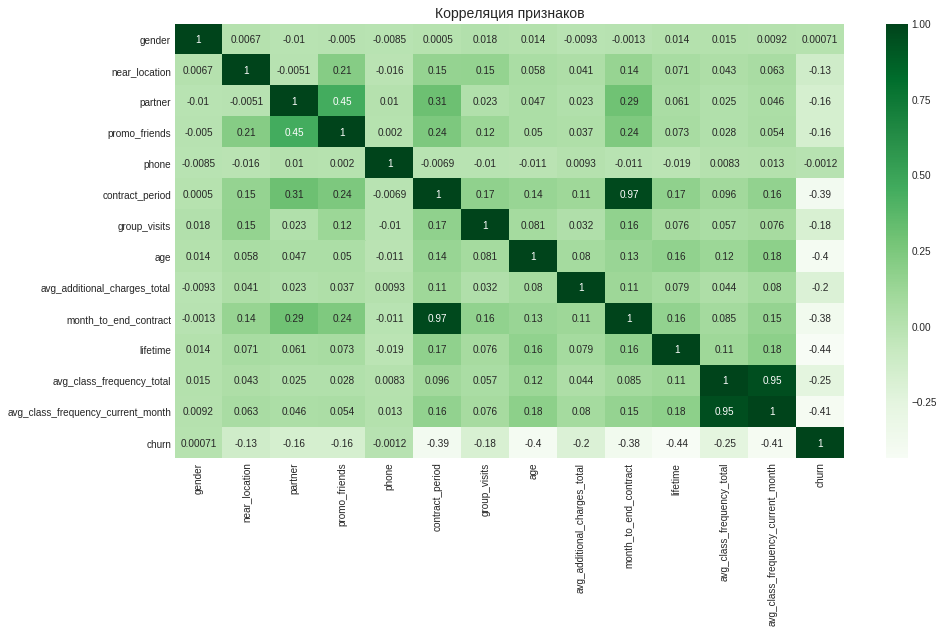

In [17]:
corr_matrix = gym_churn.corr()
_ = plt.figure(figsize=(15,8))
_ = sns.heatmap(corr_matrix, annot=True, cmap='Greens')
_ = plt.title('Корреляция признаков', fontsize=14)

In [18]:
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

У целевой переменной `churn` можно увидеть отрицательную корреляцию с переменными `lifetime` (-0.44), `avg_class_frequency_current_month` (-0.41), `contract_period` (-0.39), `month_to_end_contract` (-0.38), что согласуется с анализом средних выше (уходящие меньше задерживаются в фитнес-центре, реже посещают групповые занятия, берут более короткие абонементы). 

Видна положительная корреляция между признаками `partner` и `promo_friends` (0.45), `contract_period` и `partner` (0.31), `month_to_end_contract` и `partner` (0.29), но она недостаточно сильная, чтобы удалять какие-то из этих признаков.  

Однако, тепловая карта показывает, что между собой сильно коррелируют `month_to_end_contract` и `contract_period` (0.97), а также `avg_class_frequency_total` и `avg_class_frequency_current_month` (0.95). Удалим из датафрейма `month_to_end_contract` и `avg_class_frequency_current_month`, чтобы избежать мультиколлинеарности. 

Кроме того, анализ бинарных признаков показал, что пол и наличие телефона тоже не различаются в группах клиентов и ушедших клиентов - эти столбцы также можно удалить. Переменную `contract_period` преобразуем в категорию и преобразуем ее в множество бинарных полей с помощью `pd.get_dummies()`. На выходе получим новый датафрейм `gym_churn_new`.

In [19]:
gym_churn_new = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_current_month', 'gender', 'phone'], 
                               axis=1)
gym_churn_new['contract_period'] = gym_churn_new['contract_period'].astype('category')
gym_churn_new = pd.get_dummies(gym_churn_new)
gym_churn_new.info()
gym_churn_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
near_location                   4000 non-null int64
partner                         4000 non-null int64
promo_friends                   4000 non-null int64
group_visits                    4000 non-null int64
age                             4000 non-null int64
avg_additional_charges_total    4000 non-null float64
lifetime                        4000 non-null int64
avg_class_frequency_total       4000 non-null float64
churn                           4000 non-null int64
contract_period_1               4000 non-null uint8
contract_period_6               4000 non-null uint8
contract_period_12              4000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 293.1 KB


,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,contract_period_1,contract_period_6,contract_period_12
0,1,1,1,1,29,14.2275,3,0.0204,0,0,1,0
1,1,0,0,1,31,113.2029,7,1.9229,0,0,0,1
2,1,1,0,0,28,129.4485,2,1.8591,0,1,0,0
3,1,1,1,1,33,62.6699,2,3.2056,0,0,0,1
4,1,1,1,0,26,198.3623,3,1.1139,0,1,0,0


Итак, мы получили новый датафрейм, на котором будем строить модели прогнозирования оттока пользователей. 

### Выводы <a id="step2.1"></a> 

- отток клиентов составляет 26.5%,
- процентное соотношение мужчин и женщин примерно одинаковое,
- большинство клиентов живут или работают неподалеку от фитнес-центра,
- примерно половина пользуется партнерской программой,
- с 90% клиентов можно связаться по телефону,
- около 40% посещают групповые программы.
- средний возраст клиентов - 30 лет, при этом максимальный - всего 41,
- суммарная выручка от других услуг фитнес-центра составляет 147 у.е. на клиента,
- среднее время посещений - 3 месяца,
- клиенты ходят в фитнес-центр примерно два раза в неделю.

Предварительный анализ позволяет предположить, что клиенты, которые уходят:
- находятся дальше от фитнес-центра,
- меньше участвуют в партнерской программе и акции "приведи друга",
- реже посещают групповые программы,
- в среднем на три года моложе (медиана - 27 лет),
- примерно на 40 у.е. меньше тратят на другие услуги фитнес-центра,
- в среднем меньше посещают фитнес-центр в неделю (1-1,5 занятий против 2х),
- берут абонемент на один месяц,
- остаются с фитнес-центром меньше(1 месяц против 4х).


Для построения моделей мы сделали новый датафрейм `gym_churn_new`, которого удалили столбцы `gender`, `phone`, так как они не влияют на отток, а также столбцы `month_to_end_contract` и `avg_class_frequency_current_month`, чтобы избавиться от мультиколлинеарности признаков. Столбец `contract_period` был преобразован в множество бинарных полей.

# Шаг 3. Построение модели прогнозирования оттока пользователей <a id="step3"></a> 

## Логистическая регрессия <a id="step3.1"></a> 

Выделим целевую переменную y и матрицу признаков X, разделим данные на обучающую и тестовую выборки с учетом дисбаланса классов (отток составляет около 26%) - укажем параметр `stratify = y`. 

Далее стандартизируем данные и применим модель логистической регрессии. Посчитаем прогнозы и вероятности.

In [20]:
X = gym_churn_new.drop(columns = ['churn'])
y = gym_churn_new['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
X_test_st = scaler.transform(X_test)

model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_st, y_train)

y_pred_lr = model_lr.predict(X_test_st)
y_pred_lr[:20]

probabilities_lr = model_lr.predict_proba(X_test_st)[:,1]
probabilities_lr[:20]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

array([7.68384830e-01, 7.75697819e-02, 1.14473601e-02, 4.03754640e-02,
       2.00551650e-02, 4.10493858e-03, 7.48433936e-05, 9.88072995e-02,
       6.76550853e-01, 1.71954725e-02, 2.60369196e-03, 4.82202396e-01,
       3.16615413e-03, 9.71847266e-01, 9.07167578e-01, 2.76862536e-02,
       1.67607280e-01, 3.06566630e-01, 3.78038969e-01, 2.58157012e-04])

В качестве метрик возьмем матрицу ошибок (`confusion matrix`), долю правильных ответов (`accuracy`), точность (`precision`), полноту (`recall`) на основе значений прогнозного класса и добавим площадь под кривой ошибок (`roc_auc`) на основе вероятностей.

In [21]:
print('Метрики логистической регрессии')
'Confusion matrix: {}'.format((confusion_matrix(y_test, y_pred_lr)).ravel())
'Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_lr))
'Precision: {:.2f}'.format(precision_score(y_test, y_pred_lr))
'Recall: {:.2f}'.format(recall_score(y_test, y_pred_lr))
'ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_lr))

Метрики логистической регрессии


'Confusion matrix: [550  38  37 175]'

'Accuracy: 0.91'

'Precision: 0.82'

'Recall: 0.83'

'ROC_AUC: 0.96'

## Случайный лес <a id="step3.2"></a> 

Сделаем то же самое для модели случайный лес.

In [22]:
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_rf.fit(X_train_st, y_train)

y_pred_rf = model_rf.predict(X_test_st)
y_pred_rf[:20]

probabilities_rf = model_rf.predict_proba(X_test_st)[:,1]
probabilities_rf[:20]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])

array([0.92, 0.02, 0.01, 0.02, 0.02, 0.03, 0.01, 0.32, 0.89, 0.02, 0.  ,
       0.64, 0.  , 0.97, 0.77, 0.05, 0.36, 0.33, 0.45, 0.01])

In [23]:
print('Метрики случайного леса')
'Confusion matrix: {}'.format((confusion_matrix(y_test, y_pred_rf)).ravel())
'Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_rf))
'Precision: {:.2f}'.format(precision_score(y_test, y_pred_rf))
'Recall: {:.2f}'.format(recall_score(y_test, y_pred_rf))
'ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_rf))

Метрики случайного леса


'Confusion matrix: [558  30  49 163]'

'Accuracy: 0.90'

'Precision: 0.84'

'Recall: 0.77'

'ROC_AUC: 0.95'

### Выводы <a id="step3.3"></a> 

Метрики показывают, что модели в основном различаются по определению точности (`precision`) и полноты (`recall`), и, соответственно в том, сколько ложно-положительных и ложно-отрицательных результатов они дают. Модель линейной регрессии лучше показывает полноту (0.82 против 0.78) и дает меньше ложно-отрицательных результатов (39 против 46). А модель случайного леса лучше показывает точность (0.86 против 0.83) и дает меньше ложно-положительных результатов (28 против 36).

При этом, если предположить, что для компании важнее в принципе не упустить клиента, то больше подойдет модель, выдающая меньше ложно-отрицательных результатов. Иными словами, если модель предскажет, что клиент уйдет, и компания предпримет какие-то меры для его удержания (которые, скорее всего, будут включать некоторые материальные затраты), а он останется (ложно-положительные результат), то усилия компании могут из него сделать более лояльного пользователя, и потери будут не так велики (или даже может быть прибыль, если довольный клиент еще приведет друзей). Если же модель предскажет, что клиент останется, а он уйдет (ложно-отрицательный результат), то потери очевидны, особенно если привлечение новых клиентов обходится недешево. В данном случае больше подходит модель линейной регрессии. 

С другой стороны, анализ показал, что у компании достаточно молодая аудитория (в среднем - около 30 лет) - а она в принципе может быть более мобильной и "ищущей". И если компания старается удержаться на плаву и пока не может получить доступ к другой аудитории или новую аудиторию получает относительно легко за счет партнерских программ, ей были бы больше важны средства, вкладываемые в укрепление лояльности клиентов, и тогда больше подошла бы модель, выдающая меньше ложно-положительных результатов, и это случайный лес.

Поскольку у нас нет подробной инфориации о компании и дано, что компания сейчас борется с оттоком, предположим, что имеем дело с первым случаем и **выберем модель логистической регрессии**. 

# Шаг 4. Построение кластеризации пользователей <a id="step4"></a> 

Для разделения пользователей фитнес-центра на кластеры вернемся к исходному подготовленному датафрейму `gym_churn`, чтобы иметь наиболее полную информацию. Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и выведем дендрограмму.

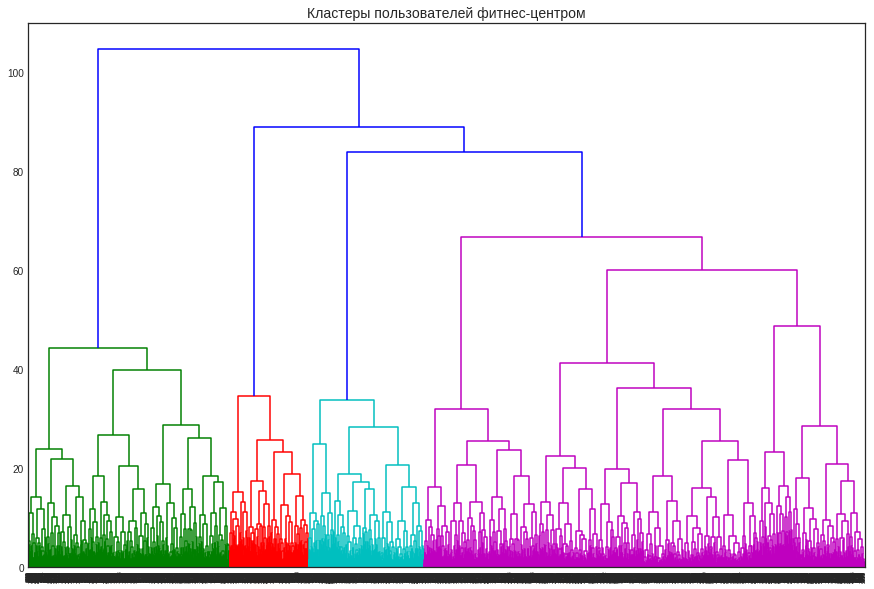

In [24]:
X = gym_churn.drop(columns = ['churn'])

X_st = scaler.fit_transform(X)

linked = linkage(X_st, method = 'ward')

_ = plt.figure(figsize=(15, 10))  
_ = dendrogram(linked, orientation='top')
_ = plt.title('Кластеры пользователей фитнес-центром', fontsize=14)
plt.show()

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Денрограмма показывает 4 кластера, но видно, что фиолетовый можно было бы разбить на два, а то и на три. Возьмем число кластеров равное 5, как указано в задании. Номер кластера добавим в таблицу `gym_churn` под названием `cluster` и выведем первые строки таблицы.

In [25]:
model_km = KMeans(n_clusters = 5, random_state = 0)

labels = model_km.fit_predict(X_st)

gym_churn['cluster'] = labels


gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.2275,5,3,0.0204,0.0000,0,1
1,0,1,0,0,1,12,1,31,113.2029,12,7,1.9229,1.9102,0,0
2,0,1,1,0,1,1,0,28,129.4485,1,2,1.8591,1.7365,0,3
3,0,1,1,1,1,12,1,33,62.6699,12,2,3.2056,3.3572,0,0
4,1,1,1,1,1,1,0,26,198.3623,1,3,1.1139,1.1201,0,3


Сразу посмотрим клиентов по кластерам и долю оттока клиентов по кластерам.

In [26]:
gym_churn.cluster.value_counts(normalize=True)

3   0.3155
0   0.2527
4   0.2092
2   0.1263
1   0.0963
Name: cluster, dtype: float64

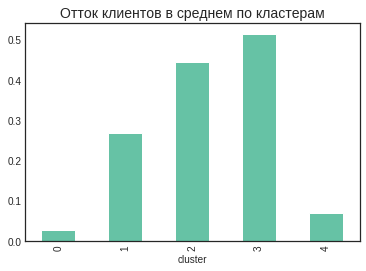

In [27]:
_ = gym_churn.groupby('cluster').churn.mean().plot(kind='bar')
_ = plt.title('Отток клиентов в среднем по кластерам', fontsize=14)

Самый большой кластер - 3й (30%), и в нем же наблюдается самый большой отток (около половины клиентов). Около 45% клиентов кластера 2 уходят, но этот кластер включает только 13% клиентов. Меньше всего уходят клиенты кластеров 0 (25% клиентов центра) и 4 (20%). В 1м кластере (10% клиентов) отток такой же, как в среднем для датасета.

Таким образом, больше всего уходит клиентов в кластерах 2 и 3 (это около 44% клиентов). Самые надежные - клиенты кластеров 0 и 4 (46% клиентов).

Посмотрим на средние значения признаков для кластеров.

In [28]:
gym_churn.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.5025,0.5221,0.4950,0.4857,0.5603
near_location,0.9594,0.8623,0.0000,1.0000,0.9761
partner,0.7834,0.4701,0.4634,0.3502,0.3560
promo_friends,0.5747,0.3065,0.0792,0.2401,0.2294
phone,1.0000,0.0000,1.0000,1.0000,0.9988
contract_period,10.8843,4.7870,2.3525,1.9485,2.6655
group_visits,0.5430,0.4260,0.2158,0.3415,0.4731
age,29.9802,29.3013,28.4772,28.1680,30.1278
avg_additional_charges_total,160.7070,143.9577,135.4575,131.6222,161.7243
month_to_end_contract,9.9505,4.4753,2.1980,1.8566,2.4552


Можно сразу разбить кластеры на три группы - с наименьшим оттоком (0 и 4), с наибольшим оттоком (2 и 3) и с оттоком, характерным для всего датасета. Внутри первой и второй групп где-то половина признаков у кластеров примерно одинакова. Посмотрим подробнее с помощью графиков.

In [29]:
gym_churn.groupby(['cluster','churn']).mean().T

cluster                                  0                 1           \
churn                                    0        1        0        1   
gender                              0.4995   0.6071   0.5213   0.5243   
near_location                       0.9593   0.9643   0.8865   0.7961   
partner                             0.7823   0.8214   0.5000   0.3883   
promo_friends                       0.5738   0.6071   0.3617   0.1553   
phone                               1.0000   1.0000   0.0000   0.0000   
contract_period                    10.9135   9.8571   5.8794   1.7961   
group_visits                        0.5483   0.3571   0.4610   0.3301   
age                                30.0743  26.6786  30.0887  27.1456   
avg_additional_charges_total      161.7380 124.5117 156.7556 108.9187   
month_to_end_contract               9.9746   9.1071   5.4681   1.7573   
lifetime                            4.8474   0.9286   5.0106   0.9515   
avg_class_frequency_total           1.9909   1.7174   1.9587   1.5420   
avg_class_frequency_current_month   1.9938   1.3598   1.9579   1.0552   

cluster                                  2                 3           \
churn                                    0        1        0        1   
gender                              0.4911   0.5000   0.4666   0.5039   
near_location                       0.0000   0.0000   1.0000   1.0000   
partner                             0.5231   0.3884   0.3785   0.3236   
promo_friends                       0.1103   0.0402   0.2561   0.2250   
phone                               1.0000   1.0000   1.0000   1.0000   
contract_period                     3.0676   1.4554   2.4535   1.4715   
group_visits                        0.2598   0.1607   0.4062   0.2804   
age                                29.6690  26.9821  29.5334  26.8783   
avg_additional_charges_total      149.1493 118.2816 150.4653 113.8243   
month_to_end_contract               2.8327   1.4018   2.3132   1.4253   
lifetime                            4.2562   0.9955   3.9739   0.9923   
avg_class_frequency_total           1.8582   1.4124   1.1095   1.3781   
avg_class_frequency_current_month   1.8623   0.9943   1.1082   0.9231   

cluster                                  4           
churn                                    0        1  
gender                              0.5603   0.5614  
near_location                       0.9744   1.0000  
partner                             0.3603   0.2982  
promo_friends                       0.2372   0.1228  
phone                               0.9987   1.0000  
contract_period                     2.7423   1.6140  
group_visits                        0.4782   0.4035  
age                                30.2718  28.1579  
avg_additional_charges_total      164.5285 123.3497  
month_to_end_contract               2.5205   1.5614  
lifetime                            5.1769   1.0526  
avg_class_frequency_total           2.8711   2.5838  
avg_class_frequency_current_month   2.8786   2.4507

Посмотрим на распределения признаков на графиках. Сначала качественные признаки.

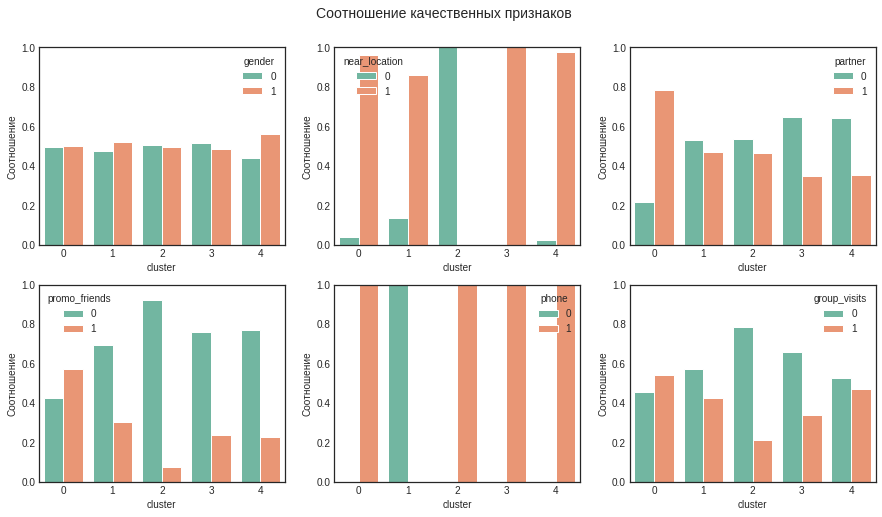

In [30]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
_ = fig.suptitle('Соотношение качественных признаков', fontsize=14, y = .95)
for ax, col in zip(axes.flat, binary_features):
    ratio = gym_churn.groupby('cluster')[col].value_counts(normalize=True).rename('Соотношение')\
                                                                            .reset_index()
    _ = sns.barplot(x='cluster', y='Соотношение', hue=col, data=ratio,  ax=ax)
    _ = ax.set(ylim = (0,1))

plt.show()

По признакам:
- в 4м кластере наблюдается небольшая разница между мужчинами и женщинами, в остальных примерно поровну,
- только во 2м кластере есть клиенты, которые не живут и не работают рядом с фитнес-центром,
- больше всего с партнерских программ приходит клиентов из кластера 0, меньше всего - с 3го и 4го,
- так же только в 0м кластере преобладают клиенты, которые участвуют в акции "приведи друга", меньше всего таких - в 2м кластере,
- номера телефона нет только в кластере 1,
- 0 - единственный кластер, где большая часть клиентов ходит на групповые занятия, меньше всего таких - в кластере 2.

Посмотрим на длительность абонементов.

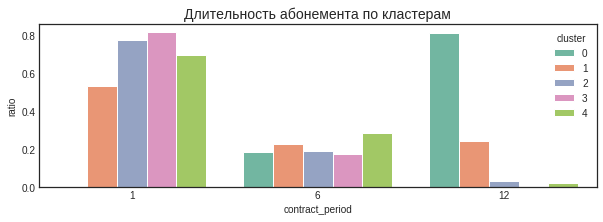

In [31]:
contract_period_cluster = gym_churn.groupby('cluster')['contract_period'].value_counts(normalize=True).rename('ratio')\
                           .reset_index()
_ = plt.figure(figsize=(10, 3))
_ = sns.barplot(data=contract_period_cluster, x='contract_period', y='ratio', hue='cluster')
_ = plt.title('Длительность абонемента по кластерам', fontsize=14)

Клиенты кластеров 1-4 предпочитают абонементы на 1 месяц, среди них больше всего из кластера 3. В кластере 0 80%  предпочитают брать на 12 месяцев и 20% - на 6. Клиенты из 3го кластера на 12 месяцев не берут.

Посмотрим на количесвенные признаки.

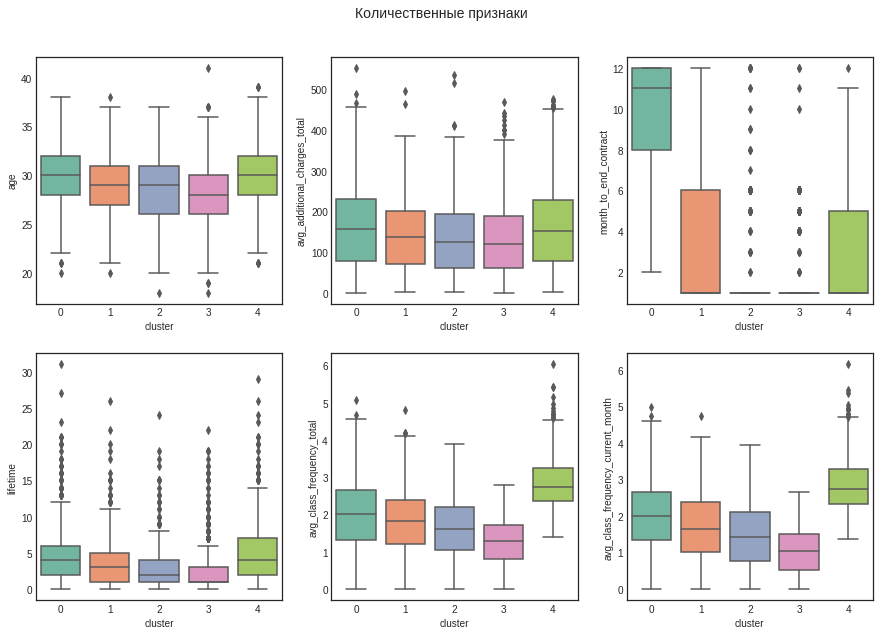

In [32]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
_ = fig.suptitle('Количественные признаки', fontsize=14, y = .95)
for ax, col in zip(axes.flat, num_features):
    _ = sns.boxplot(x='cluster', y=col,  data=gym_churn,  ax=ax)
    
plt.show()

По признакам:
- в 3м кластере самые молодые клиенты, в остальных - примерно одинаково,
- дополнительными услугами больше пользуются в 0 и 4 кластере, в 3- меньше всего,
- больше всего месяцев до окончания контракта - в кластере 0, в кластерах 2 и 3 тут больше всего выбросов,
- дольше остаются в кластерах 0 и 4, меньше - в 3м,
- посещение в среднем и за последний месяц примерно одинаково распределено; чаще всего бывают клиенты кластера 4, меньше - кластера 3.

### Выводы <a id="step4.1">

Для выводов теперь опишем кластеры по группам, разбив их по оттоку - наименьший, наибольший и средний по датасету. 

**Кластеры с наименьшим оттоком 0 (2,8%) и 4 (6,9%)**

Общие черты клиентов:
- живут или работают рядом с фитнес-центром, 
- тратят около 160 у.е. на дополнительные услуги, 
- остаются в центре примерно 4 месяца,
- находятся в возрасте 30 лет,
- у фитнес-центра есть их телефон.

Различия:
- в кластере 0 в два раза больше тех, кто пользуется партнерской программой и программой "приведи друга",
- в кластере 0 также в два раза чаще пользуются партнерскими программами,
- в кластере 0 большинство клиентов берут абонементы на 12 месяцев,
- в кластере 0 реже посещают групповые занятия.


 
**Кластеры с наибольшим оттоком 2 (44,4%) и 3 (51,4%)**

В обоих кластерах клиенты:
- моложе (в среднем 28,5 лет),
- меньше всего тратят на доп.услуги центра,
- в среднем остаются на 2,5 месяца,

Различия:
- клиенты кластера 2 больше пользуются партнерскими программами, но в отличие от клиентов кластера 3 почти не пользуются акцией "приведи друга",
- клиенты кластера 2 не живут и не работают рядом с центром,
- больше клиентов кластера 2 покупают абонементы на более длительный срок,
- клиенты кластера 3 больше ходят на групповые программы, а 2го - чаще посещают в неделю.

**Клиенты кластера 1 (26,7%)**:
- больше всего соответствуют усредненному портрету пользователя, который мы вывели в предварительном анализе данных, 
- все они почему-то не оставили центру свой номер телефона,
- в среднем ходят 4 месяца в центр.

# Шаг 5. Выводы и базовые рекомендации по работе с клиентами <a id="step5"></a> 

Мы проаналировали данные 4000 клиентов фитнес-центра с целью построить модель по прогнозу оттока клиентов и разделить клиентов на кластеры. Данные были достаточно чистые, много преобразований делать не пришлось. 

Исследовательский анализ данных показал следующее:
- отток клиентов составляет 26.5%,
- процентное соотношение мужчин и женщин примерно одинаковое,
- большинство клиентов живут или работают неподалеку от фитнес-центра,
- примерно половина пользуется партнерской программой,
- с 90% клиентов можно связаться по телефону,
- около 40% посещают групповые программы.
- средний возраст клиентов - 30 лет, при этом максимальный - всего 41,
- суммарная выручка от других услуг фитнес-центра составляет 147 у.е. на клиента,
- среднее время посещений - 3 месяца,
- клиенты ходят в фитнес-центр примерно два раза в неделю.

А также позволил предположить, что клиенты, которые уходят:
- находятся дальше от фитнес-центра,
- меньше участвуют в партнерской программе и акции "приведи друга",
- реже посещают групповые программы,
- в среднем на три года моложе (медиана - 27 лет),
- примерно на 40 у.е. меньше тратят на другие услуги фитнес-центра,
- в среднем меньше посещают фитнес-центр в неделю (1-1,5 занятий против 2х),
- берут абонемент на один месяц,
- остаются с фитнес-центром меньше(1 месяц против 4х).

## Модель прогнозирования
Для построения моделей мы сделали новый датафрейм `gym_churn_new`, которого удалили столбцы `gender`, `phone`, так как они не влияют на отток, а также столбцы `month_to_end_contract` и `avg_class_frequency_current_month`, чтобы избавиться от мультиколлинеарности признаков. Столбец `contract_period` был преобразован в множество бинарных полей.

Модель прогнозирования оттока была обучена двумя способами: логистической регрессией и случайным лесом. Метрики показали, что модели в основном различаются по определению точности (`precision`) и полноты (`recall`), и, соответственно в том, сколько ложно-положительных и ложно-отрицательных результатов они дают. Модель линейной регрессии лучше показала полноту (0.82 против 0.78) и дала меньше ложно-отрицательных результатов (39 против 46). А модель случайного леса - наоборот, лучше показала точность (0.86 против 0.83) и дала меньше ложно-положительных результатов (28 против 36). Предположив, что для компании важнее в принципе не упустить клиента, **мы выбрали модель логистической регрессии**. 


## Кластеры клиентов
Мы выделили 5 кластеров и разделили их на три группы по оттоку. Больше всего уходит клиентов в кластерах 2 и 3 (это около 44% клиентов). Самые надежные - клиенты кластеров 0 и 4 (46% клиентов). 1й кластер составляет около 10% пользователей, некий усредненный портрет.

**Кластеры с наименьшим оттоком 0 (2,8%) и 4 (6,9%)**

Общие черты клиентов:
- живут или работают рядом с фитнес-центром, 
- тратят около 160 у.е. на дополнительные услуги, 
- остаются в центре примерно 4 месяца,
- находятся в возрасте 30 лет,
- у фитнес-центра есть их телефон.

Различия:
- в кластере 0 в два раза больше тех, кто пользуется партнерской программой и программой "приведи друга",
- в кластере 0 также в два раза чаще пользуются партнерскими программами,
- в кластере 0 большинство клиентов берут абонементы на 12 месяцев,
- в кластере 0 реже посещают групповые занятия.


 
**Кластеры с наибольшим оттоком 2 (44,4%) и 3 (51,4%)**

В обоих кластерах клиенты:
- моложе (в среднем 28,5 лет),
- меньше всего тратят на доп.услуги центра,
- в среднем остаются на 2,5 месяца,

Различия:
- клиенты кластера 2 больше пользуются партнерскими программами, но в отличие от клиентов кластера 3 почти не пользуются акцией "приведи друга",
- клиенты кластера 2 не живут и не работают рядом с центром,
- больше клиентов кластера 2 покупают абонементы на более длительный срок,
- клиенты кластера 3 больше ходят на групповые программы, а 2го - чаще посещают в неделю.

**Клиенты кластера 1 (26,7%)**:
- больше всего соответствуют усредненному портрету пользователя, который мы вывели в предварительном анализе данных, 
- все они почему-то не оставили центру свой номер телефона.

## Рекомендации
Предложим рекомендации по кластерам.

**Кластер 0** - наименьший отток (2,8%), вероятно, самые лояльные клиенты с длинными абонементами, в основном приходящие с партнерских программ. Они больше всех пользуются акцией "приведи друга". Возможно, условия этой акции можно для них сделать более привлекательными, чтобы они приводили еще больше друзей. 

**Кластер 1** - средний отток (26,7%), среднестатистический клиент, не оставивший своего номера телефона. Им можно делать больше персональных предложений, в том числе продвигать акцию "приведи друга" и групповые занятия.

**Кластер 2** - большой отток (44,4%), единственная группа клиентов, находящихся далеко от фитнес-центра. Им можно порекомендовать активнее посещать групповые программы, чтобы заводить знакомства и центре и появлялись дополнительные поводы туда приезжать. Им же могут понравиться специальные условия акции "приведи друга", так как они почти ей не пользуются.

**Кластер 3** - наибольший отток (51,4%), самые молодые клиенты. Им также можно порекомендовать активнее посещать групповые программы, а еще, например, утренние и дневные программы и другие услуги по специальным ценам, так как они живут или работают недалеко от центра. Возможно, эту группу надо дополнительно исследовать, чтобы найти, что им не нравится. 

**Кластер 4** - маленький отток (6,8%), живут или работают ближе всех, старше других групп, чаще всех ходят в центр и больше всех тратят на дополнительные услуги. Они мало пользуются акцией "приведи друга". Возможно, условия этой акции можно для них также сделать более привлекательными, чтобы они приводили еще больше друзей. 